# Practica A2 AAMD


## 1. Lectura de les dades
Primer de tot, llegirem les dades dels nostres arxius TXT i els guardarem en dataframes.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from minisom import MiniSom
from collections import defaultdict
import math
import seaborn as sns


df_real_og = pd.read_csv('data/A2-real.txt', sep=';')
df_synthetic_og = pd.read_csv('data/A2-synthetic.txt', sep=',')

datasets = {
    "real": df_real_og,
    "synthetic": df_synthetic_og
}

df_synthetic_og.head()

,x1,x2,x3,x4,class
0,-0.031676,-9.912054,-0.579436,-1.044239,1
1,0.002526,6.172456,3.288339,-1.006427,5
2,0.183123,-0.387841,6.236470,-1.691491,2
3,-0.042262,-1.996272,-1.655302,-2.995311,1
4,-0.062811,-0.417072,6.657475,-3.633134,4


## 2. Pre-processament de les dades
En aquest punt, ja que ja s'han tractat els dos conjunts de dades per a eliminar outliers, dades no físiques i dades incomplertes, només treurem dels nostres dataframes les columnes que no necessitem. En el cas de les dades reals, seràn les columnes de "Class" i "Location". En el cas de les dades sintètiques, serà la columna "class".

In [11]:
df_real = df_real_og.drop(columns=["Class", "Location"])
df_synthetic = df_synthetic_og.drop(columns=["class"])

df_real.head()

# Escalar les dades per a que totes totes les variables tinguin el mateix pes 
# (si no, si una variable té un rang numèric més gran, dominarà la variància encara que no sigui més important)
scaler = StandardScaler()
df_real_scaled = scaler.fit_transform(df_real)
df_syn_scaled = scaler.fit_transform(df_synthetic)

## 3. Aplicar tècniques d’aprenentatge no supervisat
### • Principal Component Analysis (PCA)
Per aquesta tècnica d'aprenentatge haurem de trobar i representar gràficament la projecció PCA en dues dimensions, utilitzant un color diferent per a cada classe, i fer un “scree plot” de la variància acumulada.
PCA és una tècnica que redueix la dimensionalitat de les dades, i projecta les dades originals a noves variables "components principals" que expliquen la major variància possible.
#### Dades reals

Com podem observar al Scree Plot de les dades reals, cada component captura la màxima variància possible en les dades, augmentant la variància acumulada. Això és degut a que el PCA construeix cada component principal de forma que maximiza la variança no explicada pels components anterior, per tant a cada component que es suma, sempre aportarà informació adicional (encada que a menor mesura).

En la representació 2D de les dades reals, es projecten les dades sobre els primers components principals (PC1 i PC2), que capturen la major part de la variança del conjunt original. Hem utilitzat la columna "classe" de les dades reals (no utilitzada per l'aprenentatge) per diferenciar amb colors els grups separats. 
A la classe 2, per exemple, es veu molt clarament com el PCA ha reduit la dimensionalitat mantenint una bona part de la estructura, però amb les classes 1 i 3 es veu que algunes dades es solapen entre elles. Això podria ser per similituds estructurals entre aquestes classes, o limitacions del mètode PCA.

#### Dades sintètiques

### • t-distributed Neighbor Stochastic Embedding (t-SNE)


### • k-means


### • Agglomerative Hierarchical Clustering (AHC)


#### Real

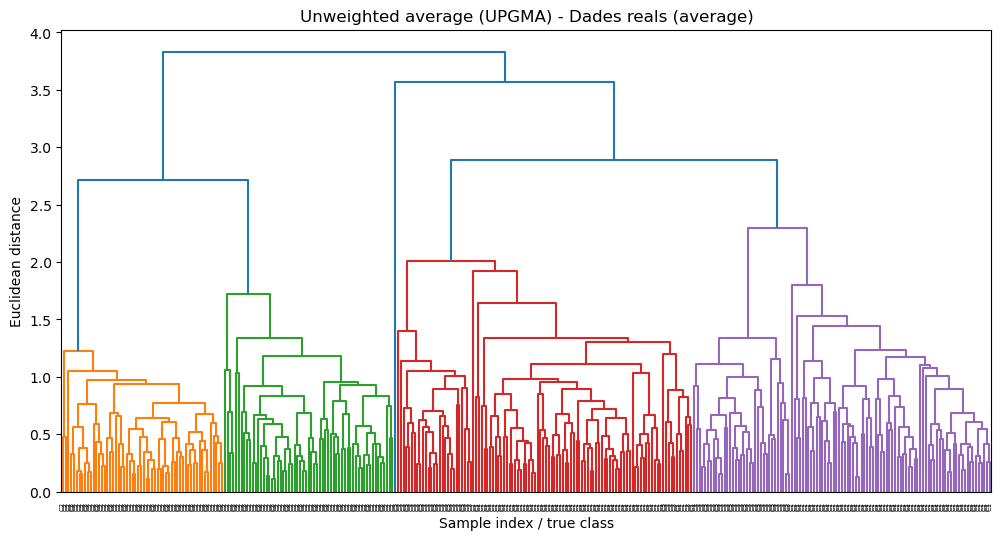

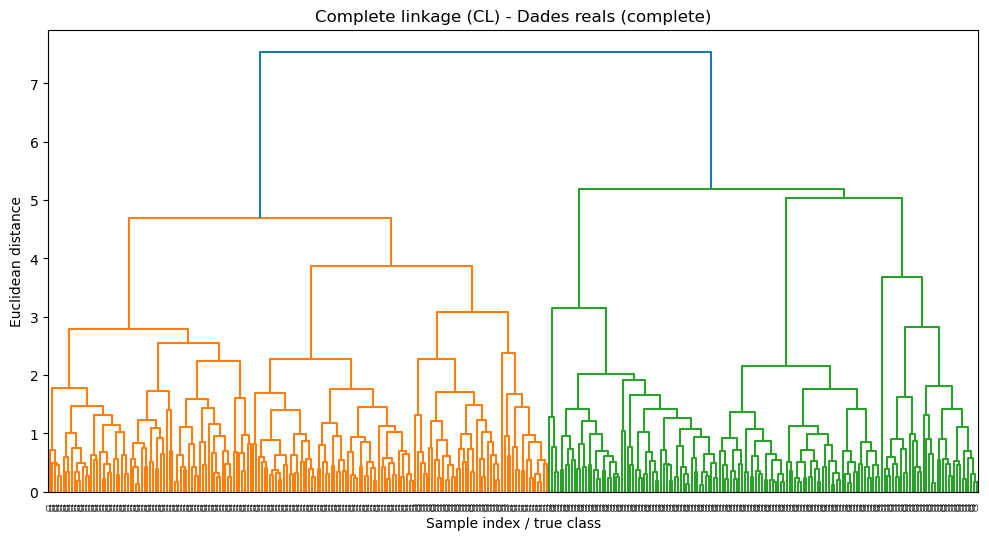

In [ ]:
# Función para mostrar dendograma
def draw_dendrogram(dist_matrix, labels, method='average', title='Dendrograma'):
    plt.figure(figsize=(12, 6))
    linked_matrix = linkage(dist_matrix, method=method)
    dendrograma = dendrogram(
        linked_matrix, 
        labels=labels, 
        leaf_rotation=90,
        )
    plt.title(f'{title} ({method})')
    plt.xlabel('Sample index / true class')
    plt.ylabel('Euclidean distance')
    plt.show()


real_dist_matrix = pdist(df_real_scaled, metric='euclidean')
labels = df_real_og["Class"].astype(str).tolist()

draw_dendrogram(real_dist_matrix, labels, method='average', title='Unweighted average (UPGMA) - Dades reals')
draw_dendrogram(real_dist_matrix, labels, method='complete', title='Complete linkage (CL) - Dades reals')

#### Synthetic

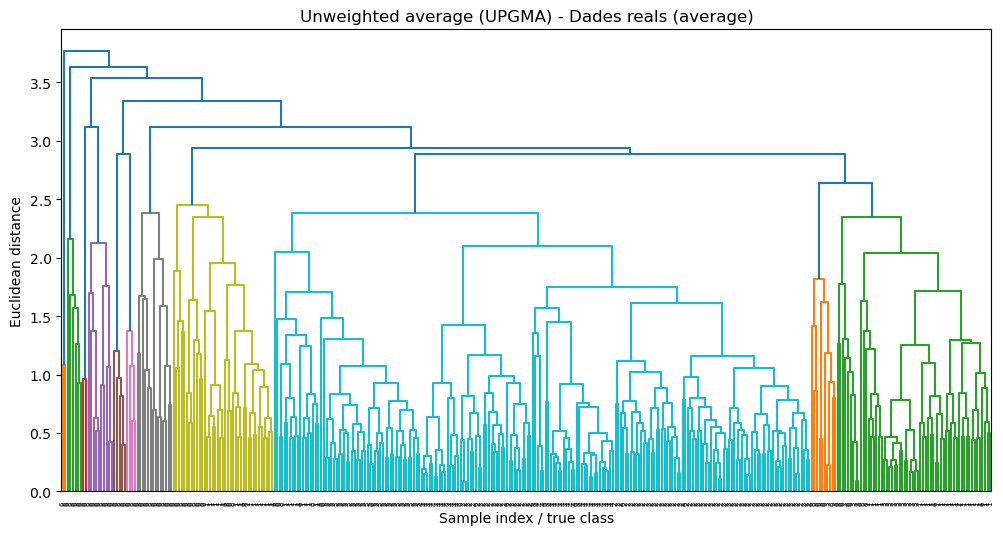

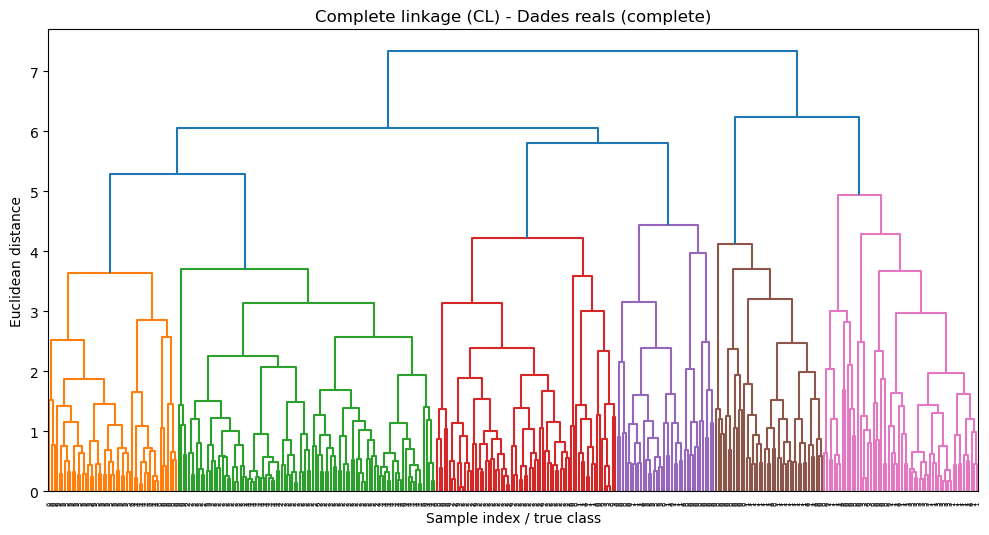

In [ ]:
synthetic_dist_matrix = pdist(df_syn_scaled, metric='euclidean')
labels = df_synthetic_og["class"].astype(str).tolist()

draw_dendrogram(synthetic_dist_matrix, labels, method='average', title='Unweighted average (UPGMA) - Dades sintetiques')
draw_dendrogram(synthetic_dist_matrix, labels, method='complete', title='Complete linkage (CL) - Dades sintetiques')

### • Autoencoder


#### Real

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


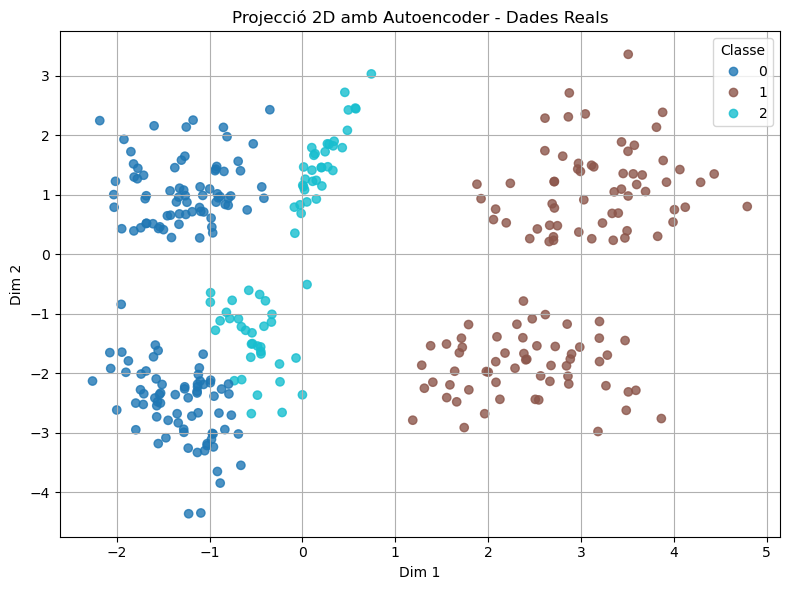

In [57]:
# 1. Crear un autoencoder simple (arquitectura simétrica)
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(2, activation='linear', name="bottleneck")(encoded)  # salida 2D

    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, output_layer)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder

# 2. Preparar y entrenar
input_dim = df_real_scaled.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)

autoencoder.compile(optimizer=Adam(learning_rate=0.02), loss='mse')

history = autoencoder.fit(df_real_scaled, df_real_scaled,
                          epochs=100,
                          batch_size=16,
                          shuffle=True,
                          verbose=0)  # poner a 1 si quieres ver el progreso

# 3. Proyectar a 2D usando el encoder
encoded_data = encoder.predict(df_real_scaled)

# 4. Graficar resultados
labels = df_real_og["Class"].astype("category")
codes = labels.cat.codes

plt.figure(figsize=(8, 6))
scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels.cat.codes, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Classe")
plt.title("Projecció 2D amb Autoencoder - Dades Reals")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Synthetic

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


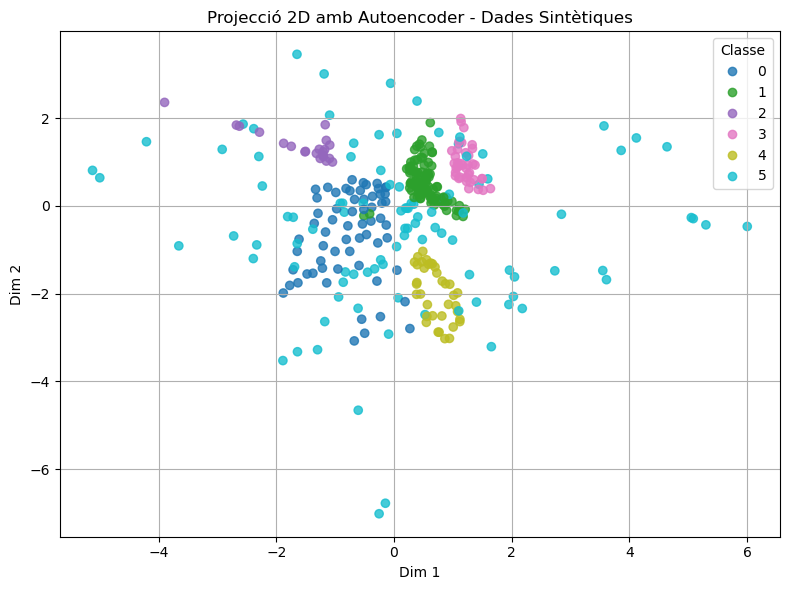

In [64]:
# 1. Preparar autoencoder para dades sintètiques
input_dim = df_syn_scaled.shape[1]
autoencoder_syn, encoder_syn = build_autoencoder(input_dim)

autoencoder_syn.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 2. Entrenar l'autoencoder
history_syn = autoencoder_syn.fit(df_syn_scaled, df_syn_scaled,
                                  epochs=100,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0)

# 3. Projectar a 2D amb el codificador
encoded_data_syn = encoder_syn.predict(df_syn_scaled)

# 4. Etiquetes
labels_syn = df_synthetic_og["class"].astype("category")
codes_syn = labels_syn.cat.codes

# 5. Gràfic
plt.figure(figsize=(8, 6))
scatter_syn = plt.scatter(encoded_data_syn[:, 0], encoded_data_syn[:, 1], 
                          c=codes_syn, cmap='tab10', alpha=0.8)

plt.legend(*scatter_syn.legend_elements(), title="Classe")
plt.title("Projecció 2D amb Autoencoder - Dades Sintètiques")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### • Self-Organizing Maps (SOM)


#### Real

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.3615453747315499


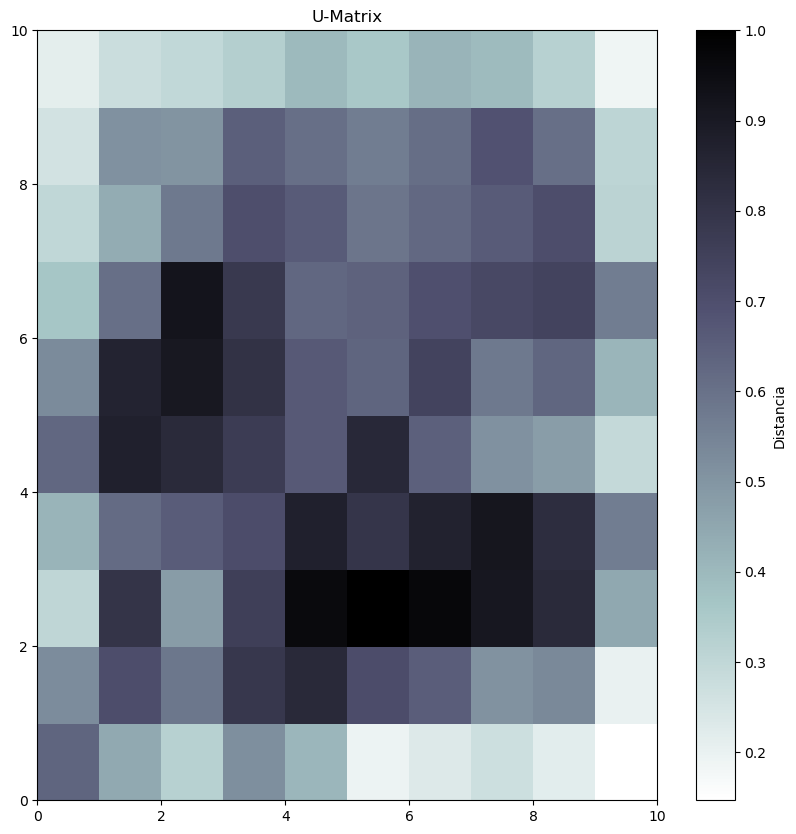

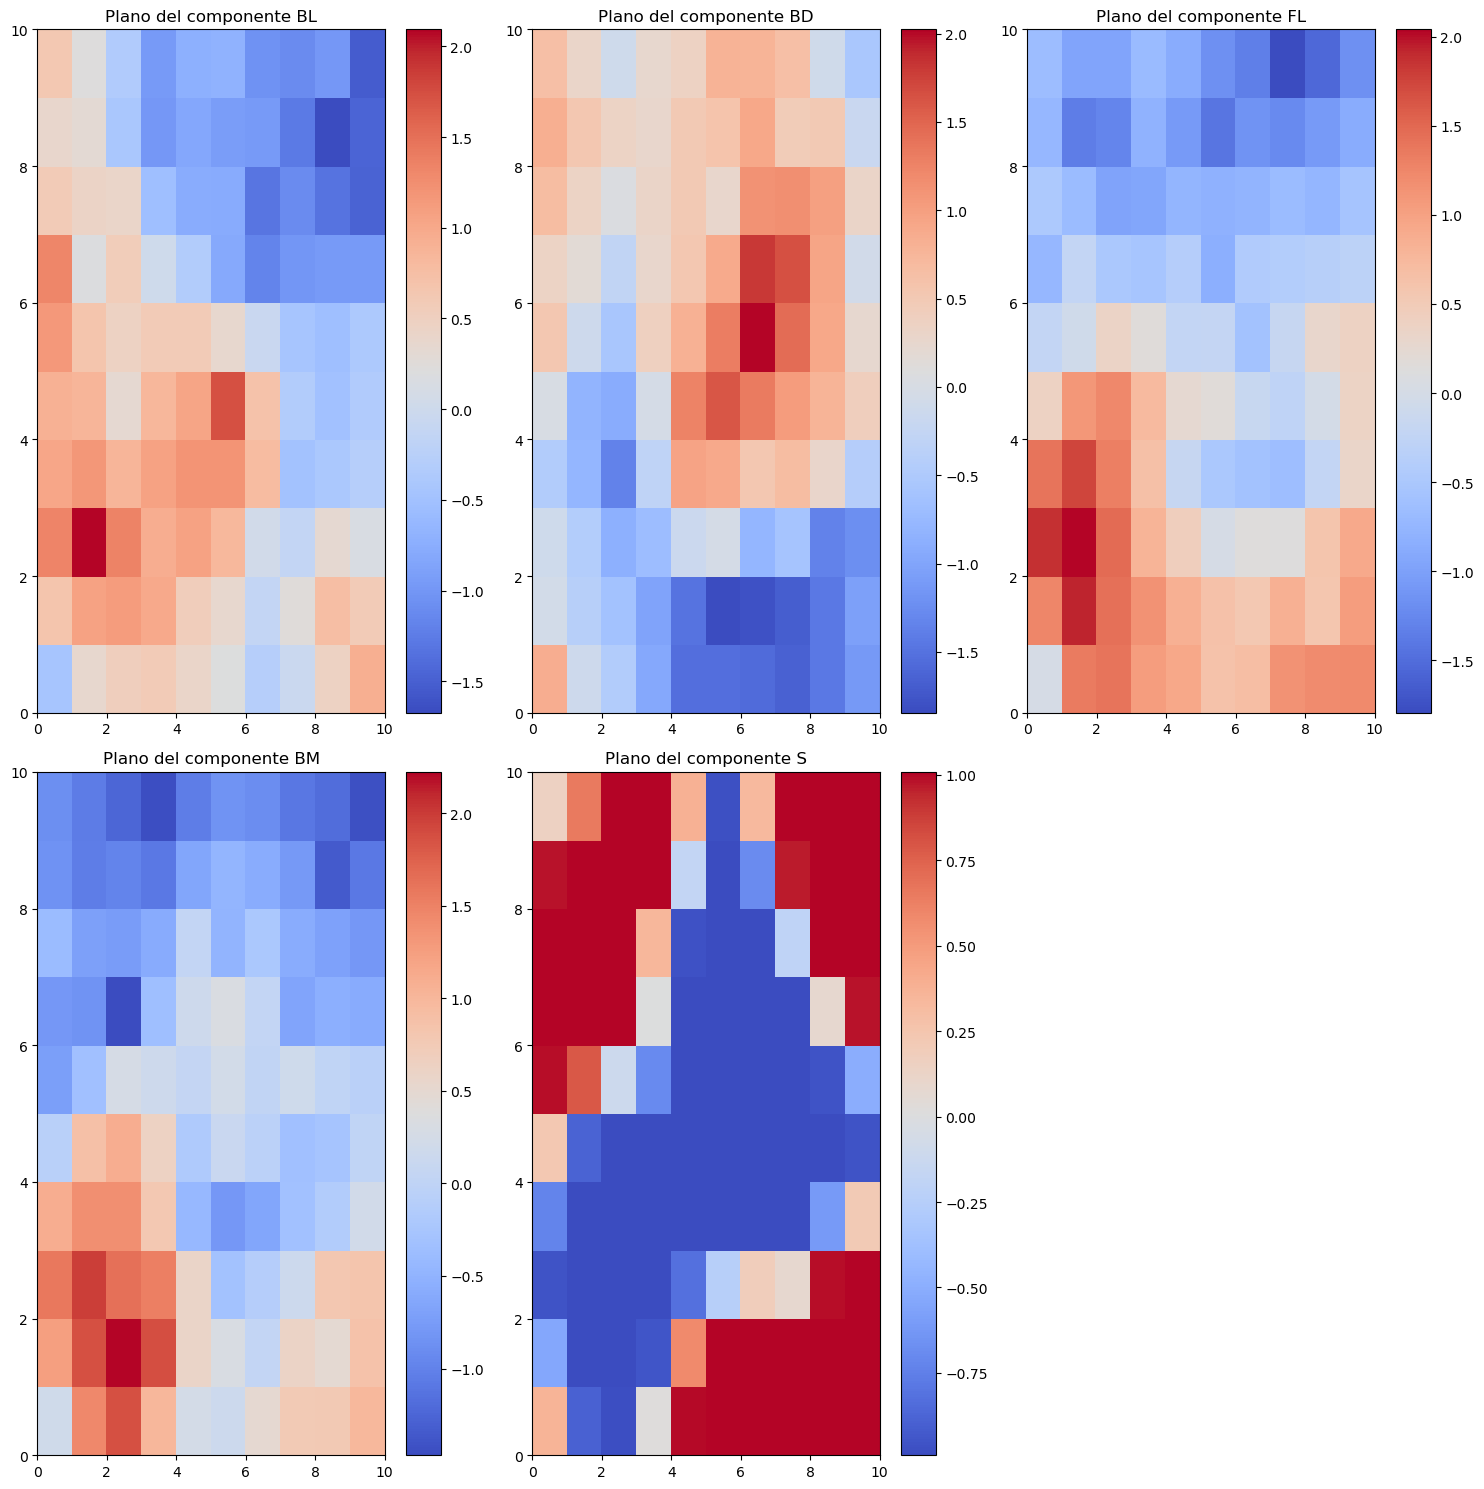

In [65]:
# Definir dimensiones del mapa
som_width = 10
som_height = 10

# Inicializar el SOM
som = MiniSom(x=som_width, y=som_height, input_len=df_real_scaled.shape[1], sigma=1.0, learning_rate=0.7, neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(df_real_scaled)

# Entrenar el SOM
som.train_random(data=df_real_scaled, num_iteration=1000, verbose=True)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # Transponer para una visualización adecuada
plt.colorbar(label='Distancia')
plt.title('U-Matrix')
plt.show()


plt.figure(figsize=(15, 15))
for i in range(num_features):
    plt.subplot(int(np.ceil(num_features / 3)), 3, i + 1)
    plt.pcolor(weights[:, :, i].T, cmap='coolwarm')
    plt.title(f'Plano del componente {df_real.columns[i]}')
    plt.colorbar()
plt.tight_layout()
plt.show()

#### Synthetic

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.46807800804060395


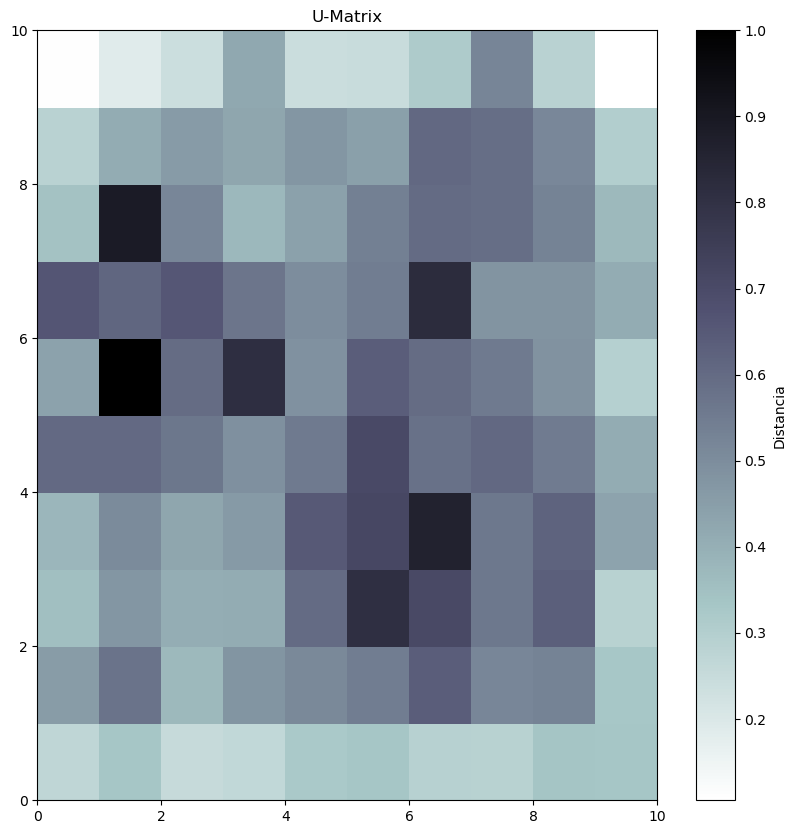

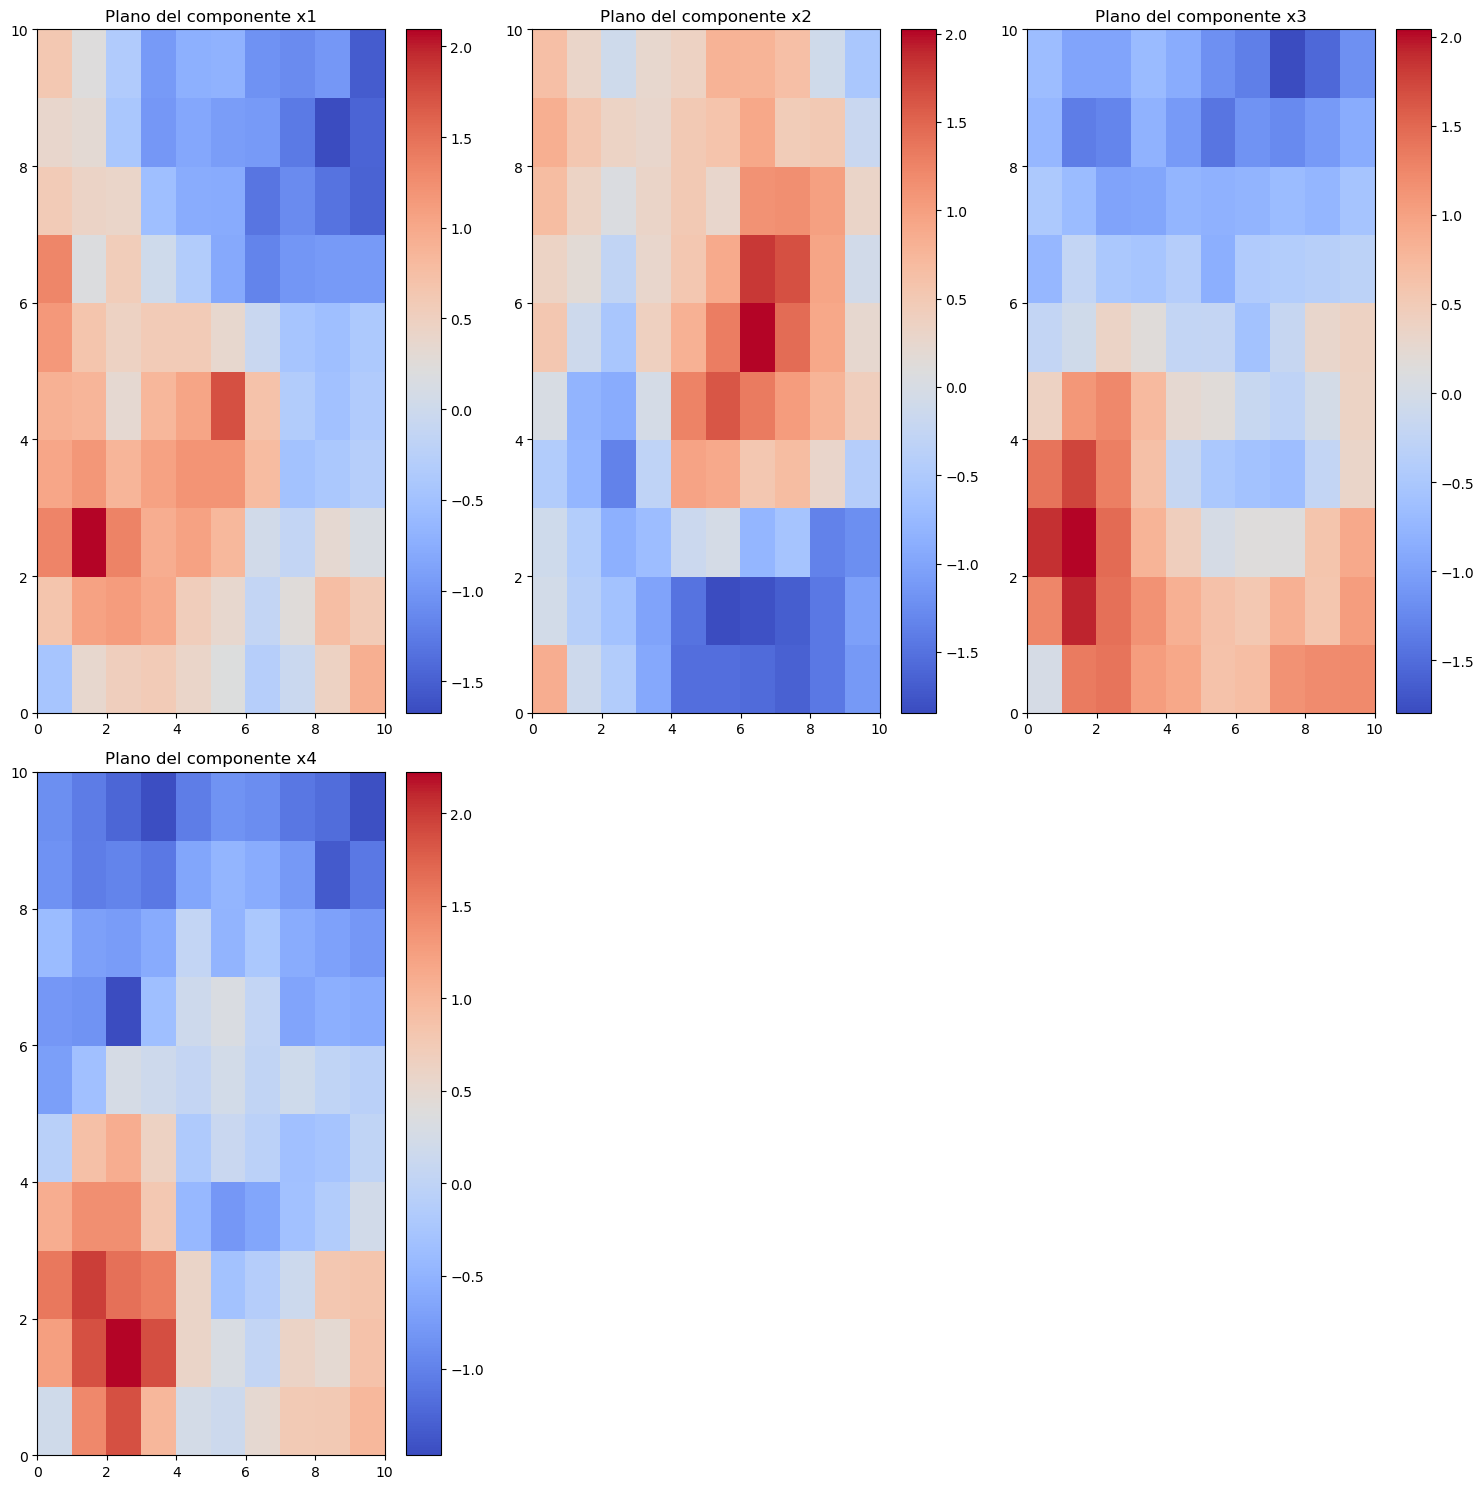

In [ ]:
# Inicializar el SOM
som2 = MiniSom(x=som_width, y=som_height, input_len=df_syn_scaled.shape[1], sigma=1.0, learning_rate=0.7, neighborhood_function='gaussian', random_seed=42)

som2.random_weights_init(df_syn_scaled)

# Entrenar el SOM
som2.train_random(data=df_syn_scaled, num_iteration=1000, verbose=True)

plt.figure(figsize=(10, 10))
plt.pcolor(som2.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distancia')
plt.title('U-Matrix')
plt.show()


plt.figure(figsize=(15, 15))
num_features = df_synthetic.shape[1]
for i in range(num_features):
    plt.subplot(int(np.ceil(num_features / 3)), 3, i + 1)
    plt.pcolor(weights[:, :, i].T, cmap='coolwarm')
    plt.title(f'Plano del componente {df_synthetic.columns[i]}')
    plt.colorbar()
plt.tight_layout()
plt.show()